# Data Engineering Pipeline: Zimbabwe Population-Specific Synthetic Data Transformation

### Transforming Bangladesh/South Asian maternal health datasets to Zimbabwe-specific context using mathematical modeling and Bayesian probability distributions from WHO statistics

In [55]:
!pip install matplotlib seaborn
!pip install sklearn
!pip install pandas
!pip install numpy
!pip install warnings
!pip install seaborn
!pip install scipy

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'error'


  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a last resort, set the environment variable
        SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
      
      More information is available at
      https://github.com/scikit-learn/sklearn-

ERROR: Could not find a version that satisfies the requirement warnings (from versions: none)
ERROR: No matching distribution found for warnings


In [79]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats, signal
from scipy.signal import find_peaks, butter, filtfilt
from sklearn.preprocessing import StandardScaler, LabelEncoder
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

Analyzing Source Datasets

In [58]:
# Loading first dataset
df1 = pd.read_csv('datasets/maternal_health_features_dataset.csv')
print(f"\n Dataset 1 - Maternal Health Features (Birth Weight):")
print(f"Shape: {df1.shape}")
print(f"Features: {list(df1.columns)}")


 Dataset 1 - Maternal Health Features (Birth Weight):
Shape: (200, 15)
Features: ['age', 'pre_pregnancy_bmi', 'gestational_age_weeks', 'blood_pressure_systolic', 'blood_pressure_diastolic', 'hemoglobin_level', 'number_of_prenatal_visits', 'has_diabetes', 'has_hypertension', 'smoking_status', 'alcohol_consumption', 'education_level', 'household_income', 'iron_supplementation', 'birth_weight_category']


In [59]:
# Loading second dataset
df2 = pd.read_csv('datasets/full_maternal_health_risk_data.csv')
print(f"\n Dataset 2 - Full Maternal Health Risk:")
print(f"Shape: {df2.shape}")
print(f"Features: {list(df2.columns)}")


 Dataset 2 - Full Maternal Health Risk:
Shape: (1205, 12)
Features: ['Age', 'Systolic BP', 'Diastolic', 'BS', 'Body Temp', 'BMI', 'Previous Complications', 'Preexisting Diabetes', 'Gestational Diabetes', 'Mental Health', 'Heart Rate', 'Risk Level']


In [60]:
# Dataset 1 analysis
print(f"Sample size: {len(df1)}")
print(f"Missing values: {df1.isnull().sum().sum()}")
print(f"Age range: {df1['age'].min()}-{df1['age'].max()}")
print(f"Has hemoglobin: {'hemoglobin_level' in df1.columns}")
print(f"Has gestational age: {'gestational_age_weeks' in df1.columns}")

Sample size: 200
Missing values: 18
Age range: 18-44
Has hemoglobin: True
Has gestational age: True


In [61]:
# Dataset 2 analysis
print(f"Sample size: {len(df2)}")
print(f"Missing values: {df2.isnull().sum().sum()}")
print(f"Age range: {df2['Age'].min()}-{df2['Age'].max()}")
print(f"Risk distribution:")
for risk in df2['Risk Level'].value_counts().items():
    print(f"{risk[0]}: {risk[1]} ({risk[1]/len(df1)*100:.1f}%)")


Sample size: 1205
Missing values: 53
Age range: 10-325
Risk distribution:
Low: 713 (356.5%)
High: 474 (237.0%)


# Data preparation for merging

In [66]:
# Standardizing column names
df2_processed = df2.copy()
df2_processed.columns = df2_processed.columns.str.lower().str.replace(' ', '_')

# Renaming for consistency
df2_processed = df2_processed.rename(columns={
    'age': 'age',
    'systolic_bp': 'blood_pressure_systolic',
    'diastolic': 'blood_pressure_diastolic',
    'bs': 'blood_sugar',
    'body_temp': 'body_temperature',
    'bmi': 'bmi',
    'heart_rate': 'heart_rate',
    'risk_level': 'risk_level_original'
})

print(f"\n Standardized Dataset 2, df2_processed: {df2_processed.shape}, Features: {list(df2_processed.columns)}")



 Standardized Dataset 2, df2_processed: (1205, 12), Features: ['age', 'blood_pressure_systolic', 'blood_pressure_diastolic', 'blood_sugar', 'body_temperature', 'bmi', 'previous_complications', 'preexisting_diabetes', 'gestational_diabetes', 'mental_health', 'heart_rate', 'risk_level_original']


In [67]:
# Adding missing critical features from statistical imputation
# Feature 1: Hemoglobin (critical for Zimbabwe - 31% anemia)
# Imputing based on risk level and correlation with other vitals
def impute_hemoglobin(row):
    """
    Imputing hemoglobin based on clinical correlations
    Low hemoglobin correlates with: high risk, low BP, high HR
    """
    base_hb = 12.0  # Normal baseline
    
    # Adjusting for risk level
    if row['risk_level_original'] == 'High':
        base_hb -= 2.0  # High risk - likely anemic
    elif row['risk_level_original'] == 'Mid':
        base_hb -= 0.8
    
    # Adjusting for blood pressure (low BP may indicate anemia)
    if row['blood_pressure_systolic'] < 100:
        base_hb -= 0.5
    
    # Adjusting for heart rate (compensatory tachycardia in anemia)
    if row['heart_rate'] > 85:
        base_hb -= 0.3
    
    # Adding noise
    base_hb += np.random.normal(0, 0.5)
    
    return max(7.0, min(16.0, base_hb))

df2_processed['hemoglobin_level'] = df2_processed.apply(impute_hemoglobin, axis=1)
print(f"Hemoglobin imputed (mean: {df2_processed['hemoglobin_level'].mean():.2f} g/dL)")

# Feature 2: Gestational Age
df2_processed['gestational_age_weeks'] = np.random.choice(
    [35, 36, 37, 38, 39, 40], 
    size=len(df2_processed),
    p=[0.05, 0.10, 0.15, 0.25, 0.30, 0.15]  # Higher probability for term
)
print(f"Gestational age assigned (mean: {df2_processed['gestational_age_weeks'].mean():.1f} weeks)")

# Feature 3: Parity (inferred from age)
def assign_parity(age, risk):
    """Assigning parity based on age and risk factors"""
    if age < 20:
        return np.random.choice([0, 1], p=[0.7, 0.3])
    elif age < 25:
        return np.random.choice([0, 1, 2], p=[0.3, 0.5, 0.2])
    elif age < 30:
        return np.random.choice([1, 2, 3], p=[0.2, 0.5, 0.3])
    elif age < 35:
        return np.random.choice([2, 3, 4], p=[0.3, 0.4, 0.3])
    else:  # 35+
        return np.random.choice([3, 4, 5, 6], p=[0.3, 0.3, 0.2, 0.2])

df2_processed['parity'] = df2_processed.apply(
    lambda row: assign_parity(row['age'], row['risk_level_original']), axis=1
)
print(f"Parity assigned (mean: {df2_processed['parity'].mean():.1f})")

# Feature 4: Previous PPH & C-Section
df2_processed['previous_pph'] = (
    (df2_processed['previous_complications'] == 1) & 
    (np.random.random(len(df2_processed)) < 0.4)
).astype(int)

df2_processed['previous_csection'] = (
    (df2_processed['parity'] > 0) & 
    (np.random.random(len(df2_processed)) < 0.18)
).astype(int)

print(f"Previous PPH: {df2_processed['previous_pph'].sum()} cases")
print(f"Previous C-Section: {df2_processed['previous_csection'].sum()} cases")

# Feature 5: Prenatal visits
def assign_prenatal_visits(risk, age):
    """Assign prenatal visits based on risk and age"""
    if risk == 'High':
        return np.random.poisson(5)  # High risk - fewer visits (missed care)
    elif risk == 'Mid':
        return np.random.poisson(7)
    else:
        return np.random.poisson(8)

df2_processed['number_of_prenatal_visits'] = df2_processed.apply(
    lambda row: max(0, min(15, assign_prenatal_visits(row['risk_level_original'], row['age']))),
    axis=1
)
print(f"Prenatal visits assigned (mean: {df2_processed['number_of_prenatal_visits'].mean():.1f})")

df2_processed.drop(columns=["risk_level_original"], inplace=True)

print(f"\n Enhanced dataset shape: {df2_processed.shape}")

Hemoglobin imputed (mean: 11.12 g/dL)
Gestational age assigned (mean: 38.1 weeks)
Parity assigned (mean: 2.0)
Previous PPH: 78 cases
Previous C-Section: 186 cases
Prenatal visits assigned (mean: 6.8)

 Enhanced dataset shape: (1205, 17)


# Extracting Zimbabwe Statistics from WHO Data

In [69]:
# Based on WHO statistics
ZIMBABWE_STATS = {
    # Demographics
    'anemia_prevalence': 0.31,  # 31% (WHO-aligned)
    'maternal_age_mean': 28.5,
    'maternal_age_std': 6.5,
    'advanced_maternal_age_rate': 0.28,  # >35 years
    
    # Physiological
    'baseline_hemoglobin_mean': 11.2,  # g/dL (accounting for anemia)
    'baseline_hemoglobin_std': 1.4,
    'anemic_hemoglobin_mean': 9.5,
    'anemic_hemoglobin_std': 0.8,
    
    # BMI
    'bmi_mean': 24.8,
    'bmi_std': 4.5,
    'obesity_rate': 0.15,  # BMI > 30
    
    # Parity
    'parity_mean': 2.8,  # Higher than Western cohorts
    'parity_lambda': 2.3,  # Poisson distribution parameter
    
    # Blood Pressure (higher baseline stress)
    'sbp_mean': 118,
    'sbp_std': 15,
    'dbp_mean': 75,
    'dbp_std': 11,
    'hypertension_rate': 0.22,  # Higher than Bangladesh
    
    # Heart Rate (compensatory mechanisms)
    'hr_mean': 78,
    'hr_std': 9,
    
    # Diabetes
    'diabetes_prevalence': 0.08,  # Lower than South Asia
    'gestational_diabetes_rate': 0.06,
    
    # Prenatal Care
    'inadequate_care_rate': 0.35,  # <4 visits
    'average_visits': 5.2,
    
    # Gestational Age
    'preterm_rate': 0.18,  # <37 weeks
    'term_mean': 38.2,
}

print("\n ZIMBABWE BASELINE PARAMETERS:")
for key, value in ZIMBABWE_STATS.items():
    if isinstance(value, float) and value < 1:
        print(f"{key:30s}: {value*100:5.1f}%")
    else:
        print(f"{key:30s}: {value:5.2f}")


 ZIMBABWE BASELINE PARAMETERS:
anemia_prevalence             :  31.0%
maternal_age_mean             : 28.50
maternal_age_std              :  6.50
advanced_maternal_age_rate    :  28.0%
baseline_hemoglobin_mean      : 11.20
baseline_hemoglobin_std       :  1.40
anemic_hemoglobin_mean        :  9.50
anemic_hemoglobin_std         :  80.0%
bmi_mean                      : 24.80
bmi_std                       :  4.50
obesity_rate                  :  15.0%
parity_mean                   :  2.80
parity_lambda                 :  2.30
sbp_mean                      : 118.00
sbp_std                       : 15.00
dbp_mean                      : 75.00
dbp_std                       : 11.00
hypertension_rate             :  22.0%
hr_mean                       : 78.00
hr_std                        :  9.00
diabetes_prevalence           :   8.0%
gestational_diabetes_rate     :   6.0%
inadequate_care_rate          :  35.0%
average_visits                :  5.20
preterm_rate                  :  18.0%
term_mea

# Bayesian Transformation To Zimbabwe Context (Bangladesh(South Asia) - Zimbabwe(Sub-Saharan Africa))

In [72]:
# Creating Zimbabwe cohort
df_zimbabwe = df2_processed.copy()

print("\n Applying Population-Specific Transformations...")

# Transformation 1: Age Distribution Adjustment
print("\n1. Age Distribution Transformation:")
current_age_mean = df_zimbabwe['age'].mean()
current_age_std = df_zimbabwe['age'].std()
print(f"Bangladesh: μ={current_age_mean:.1f}, σ={current_age_std:.1f}")
print(f"Zimbabwe Target: μ={ZIMBABWE_STATS['maternal_age_mean']:.1f}, σ={ZIMBABWE_STATS['maternal_age_std']:.1f}")

# Applying z-score normalization and rescale
df_zimbabwe['age'] = (
    (df_zimbabwe['age'] - current_age_mean) / current_age_std * 
    ZIMBABWE_STATS['maternal_age_std'] + 
    ZIMBABWE_STATS['maternal_age_mean']
)
df_zimbabwe['age'] = df_zimbabwe['age'].clip(15, 50).round().astype(int)
print(f"Transformed: μ={df_zimbabwe['age'].mean():.1f}, σ={df_zimbabwe['age'].std():.1f}")

# Transformation 2: Hemoglobin - Critical for Zimbabwe (31% anemia)
print("\n2. Hemoglobin Distribution (CRITICAL - 31% Anemia Prevalence):")
current_anemia_rate = (df_zimbabwe['hemoglobin_level'] < 11.0).mean()
print(f"Current anemia rate: {current_anemia_rate*100:.1f}%")
print(f"Target anemia rate: {ZIMBABWE_STATS['anemia_prevalence']*100:.1f}%")

# Bayesian adjustment to match 31% anemia prevalence
n_total = len(df_zimbabwe)
n_anemic_target = int(n_total * ZIMBABWE_STATS['anemia_prevalence'])
n_anemic_current = (df_zimbabwe['hemoglobin_level'] < 11.0).sum()

if n_anemic_current < n_anemic_target:
    non_anemic_indices = df_zimbabwe[df_zimbabwe['hemoglobin_level'] >= 11.0].index
    to_convert = np.random.choice(
        non_anemic_indices,
        size=n_anemic_target - n_anemic_current,
        replace=False
    )
    df_zimbabwe.loc[to_convert, 'hemoglobin_level'] = np.random.normal(
        ZIMBABWE_STATS['anemic_hemoglobin_mean'],
        ZIMBABWE_STATS['anemic_hemoglobin_std'],
        size=len(to_convert)
    )
else:
    anemic_indices = df_zimbabwe[df_zimbabwe['hemoglobin_level'] < 11.0].index
    to_convert = np.random.choice(
        anemic_indices,
        size=n_anemic_current - n_anemic_target,
        replace=False
    )
    df_zimbabwe.loc[to_convert, 'hemoglobin_level'] = np.random.normal(
        ZIMBABWE_STATS['baseline_hemoglobin_mean'],
        ZIMBABWE_STATS['baseline_hemoglobin_std'],
        size=len(to_convert)
    )

# Ensuring all values are realistic
df_zimbabwe['hemoglobin_level'] = df_zimbabwe['hemoglobin_level'].clip(6.5, 16.0)
final_anemia_rate = (df_zimbabwe['hemoglobin_level'] < 11.0).mean()
print(f"Achieved anemia rate: {final_anemia_rate*100:.1f}%")
print(f"Mean Hb: {df_zimbabwe['hemoglobin_level'].mean():.2f} g/dL")

# Transformation 3: BMI Adjustment
print("\n3. BMI Distribution Transformation:")
current_bmi_mean = df_zimbabwe['bmi'].mean()
df_zimbabwe['bmi'] = df_zimbabwe['bmi'].fillna(
    np.random.normal(ZIMBABWE_STATS['bmi_mean'], ZIMBABWE_STATS['bmi_std'])
)
# Adjust distribution
df_zimbabwe['bmi'] = (
    (df_zimbabwe['bmi'] - current_bmi_mean) / df_zimbabwe['bmi'].std() * 
    ZIMBABWE_STATS['bmi_std'] + 
    ZIMBABWE_STATS['bmi_mean']
)
df_zimbabwe['bmi'] = df_zimbabwe['bmi'].clip(14, 42).round(1)
print(f"Transformed: μ={df_zimbabwe['bmi'].mean():.1f}, σ={df_zimbabwe['bmi'].std():.1f}")

# Transformation 4: Blood Pressure (Higher baseline in SSA due to stress)
print("\n4. Blood Pressure Adjustment (SSA context - higher baseline stress):")
# Systolic - fill NaN first
df_zimbabwe['blood_pressure_systolic'] = df_zimbabwe['blood_pressure_systolic'].fillna(
    np.random.normal(ZIMBABWE_STATS['sbp_mean'], ZIMBABWE_STATS['sbp_std'])
)
df_zimbabwe['blood_pressure_systolic'] = (
    df_zimbabwe['blood_pressure_systolic'] + 
    np.random.normal(8, 3, len(df_zimbabwe))
).clip(85, 180).round().astype(int)

# Diastolic - fill NaN first
df_zimbabwe['blood_pressure_diastolic'] = df_zimbabwe['blood_pressure_diastolic'].fillna(
    np.random.normal(ZIMBABWE_STATS['dbp_mean'], ZIMBABWE_STATS['dbp_std'])
)
df_zimbabwe['blood_pressure_diastolic'] = (
    df_zimbabwe['blood_pressure_diastolic'] + 
    np.random.normal(5, 2, len(df_zimbabwe))
).clip(50, 120).round().astype(int)

print(f"SBP: μ={df_zimbabwe['blood_pressure_systolic'].mean():.1f}, σ={df_zimbabwe['blood_pressure_systolic'].std():.1f}")
print(f"DBP: μ={df_zimbabwe['blood_pressure_diastolic'].mean():.1f}, σ={df_zimbabwe['blood_pressure_diastolic'].std():.1f}")

# Transformation 5: Parity (Higher in Zimbabwe)
print("\n5. Parity Distribution (Higher in Sub-Saharan Africa):")
df_zimbabwe['parity'] = np.random.poisson(ZIMBABWE_STATS['parity_lambda'], len(df_zimbabwe))
df_zimbabwe['parity'] = df_zimbabwe['parity'].clip(0, 8)
print(f"Mean parity: {df_zimbabwe['parity'].mean():.2f}")
print(f"High parity (>3): {(df_zimbabwe['parity'] > 3).mean()*100:.1f}%")

# Transformation 6: Diabetes (Lower in Zimbabwe vs South Asia)
print("\n6. Diabetes Prevalence Adjustment (Lower in SSA):")
current_diabetes_rate = df_zimbabwe['preexisting_diabetes'].mean()
print(f"Bangladesh diabetes rate: {current_diabetes_rate*100:.1f}%")
print(f"Zimbabwe target rate: {ZIMBABWE_STATS['diabetes_prevalence']*100:.1f}%")

# Reducing diabetes prevalence
n_diabetes_current = df_zimbabwe['preexisting_diabetes'].sum()
n_diabetes_target = int(len(df_zimbabwe) * ZIMBABWE_STATS['diabetes_prevalence'])

if n_diabetes_current > n_diabetes_target:
    diabetic_indices = df_zimbabwe[df_zimbabwe['preexisting_diabetes'] == 1].index
    to_remove = np.random.choice(
        diabetic_indices,
        size=int(n_diabetes_current - n_diabetes_target),
        replace=False
    )
    df_zimbabwe.loc[to_remove, 'preexisting_diabetes'] = 0

print(f"Achieved diabetes rate: {df_zimbabwe['preexisting_diabetes'].mean()*100:.1f}%")

# Transformation 7: Prenatal Care (Lower in Zimbabwe)
print("\n7. Prenatal Care Access Adjustment:")
df_zimbabwe['number_of_prenatal_visits'] = np.random.poisson(
    ZIMBABWE_STATS['average_visits'], 
    len(df_zimbabwe)
).clip(0, 15)
inadequate_care_rate = (df_zimbabwe['number_of_prenatal_visits'] < 4).mean()
print(f"Average visits: {df_zimbabwe['number_of_prenatal_visits'].mean():.1f}")
print(f"Inadequate care (<4 visits): {inadequate_care_rate*100:.1f}%")

# Save synthetic dataset
df_zimbabwe.to_csv("datasets/df_zimbabwe_processed.csv", index=False)


 Applying Population-Specific Transformations...

1. Age Distribution Transformation:
Bangladesh: μ=27.7, σ=12.6
Zimbabwe Target: μ=28.5, σ=6.5
Transformed: μ=28.5, σ=4.8

2. Hemoglobin Distribution (CRITICAL - 31% Anemia Prevalence):
Current anemia rate: 41.1%
Target anemia rate: 31.0%
Achieved anemia rate: 35.2%
Mean Hb: 11.26 g/dL

3. BMI Distribution Transformation:
Transformed: μ=24.9, σ=4.4

4. Blood Pressure Adjustment (SSA context - higher baseline stress):
SBP: μ=124.6, σ=18.6
DBP: μ=82.0, σ=14.1

5. Parity Distribution (Higher in Sub-Saharan Africa):
Mean parity: 2.31
High parity (>3): 19.4%

6. Diabetes Prevalence Adjustment (Lower in SSA):
Bangladesh diabetes rate: 28.8%
Zimbabwe target rate: 8.0%
Achieved diabetes rate: 8.0%

7. Prenatal Care Access Adjustment:
Average visits: 5.2
Inadequate care (<4 visits): 21.3%


# Data Visualization

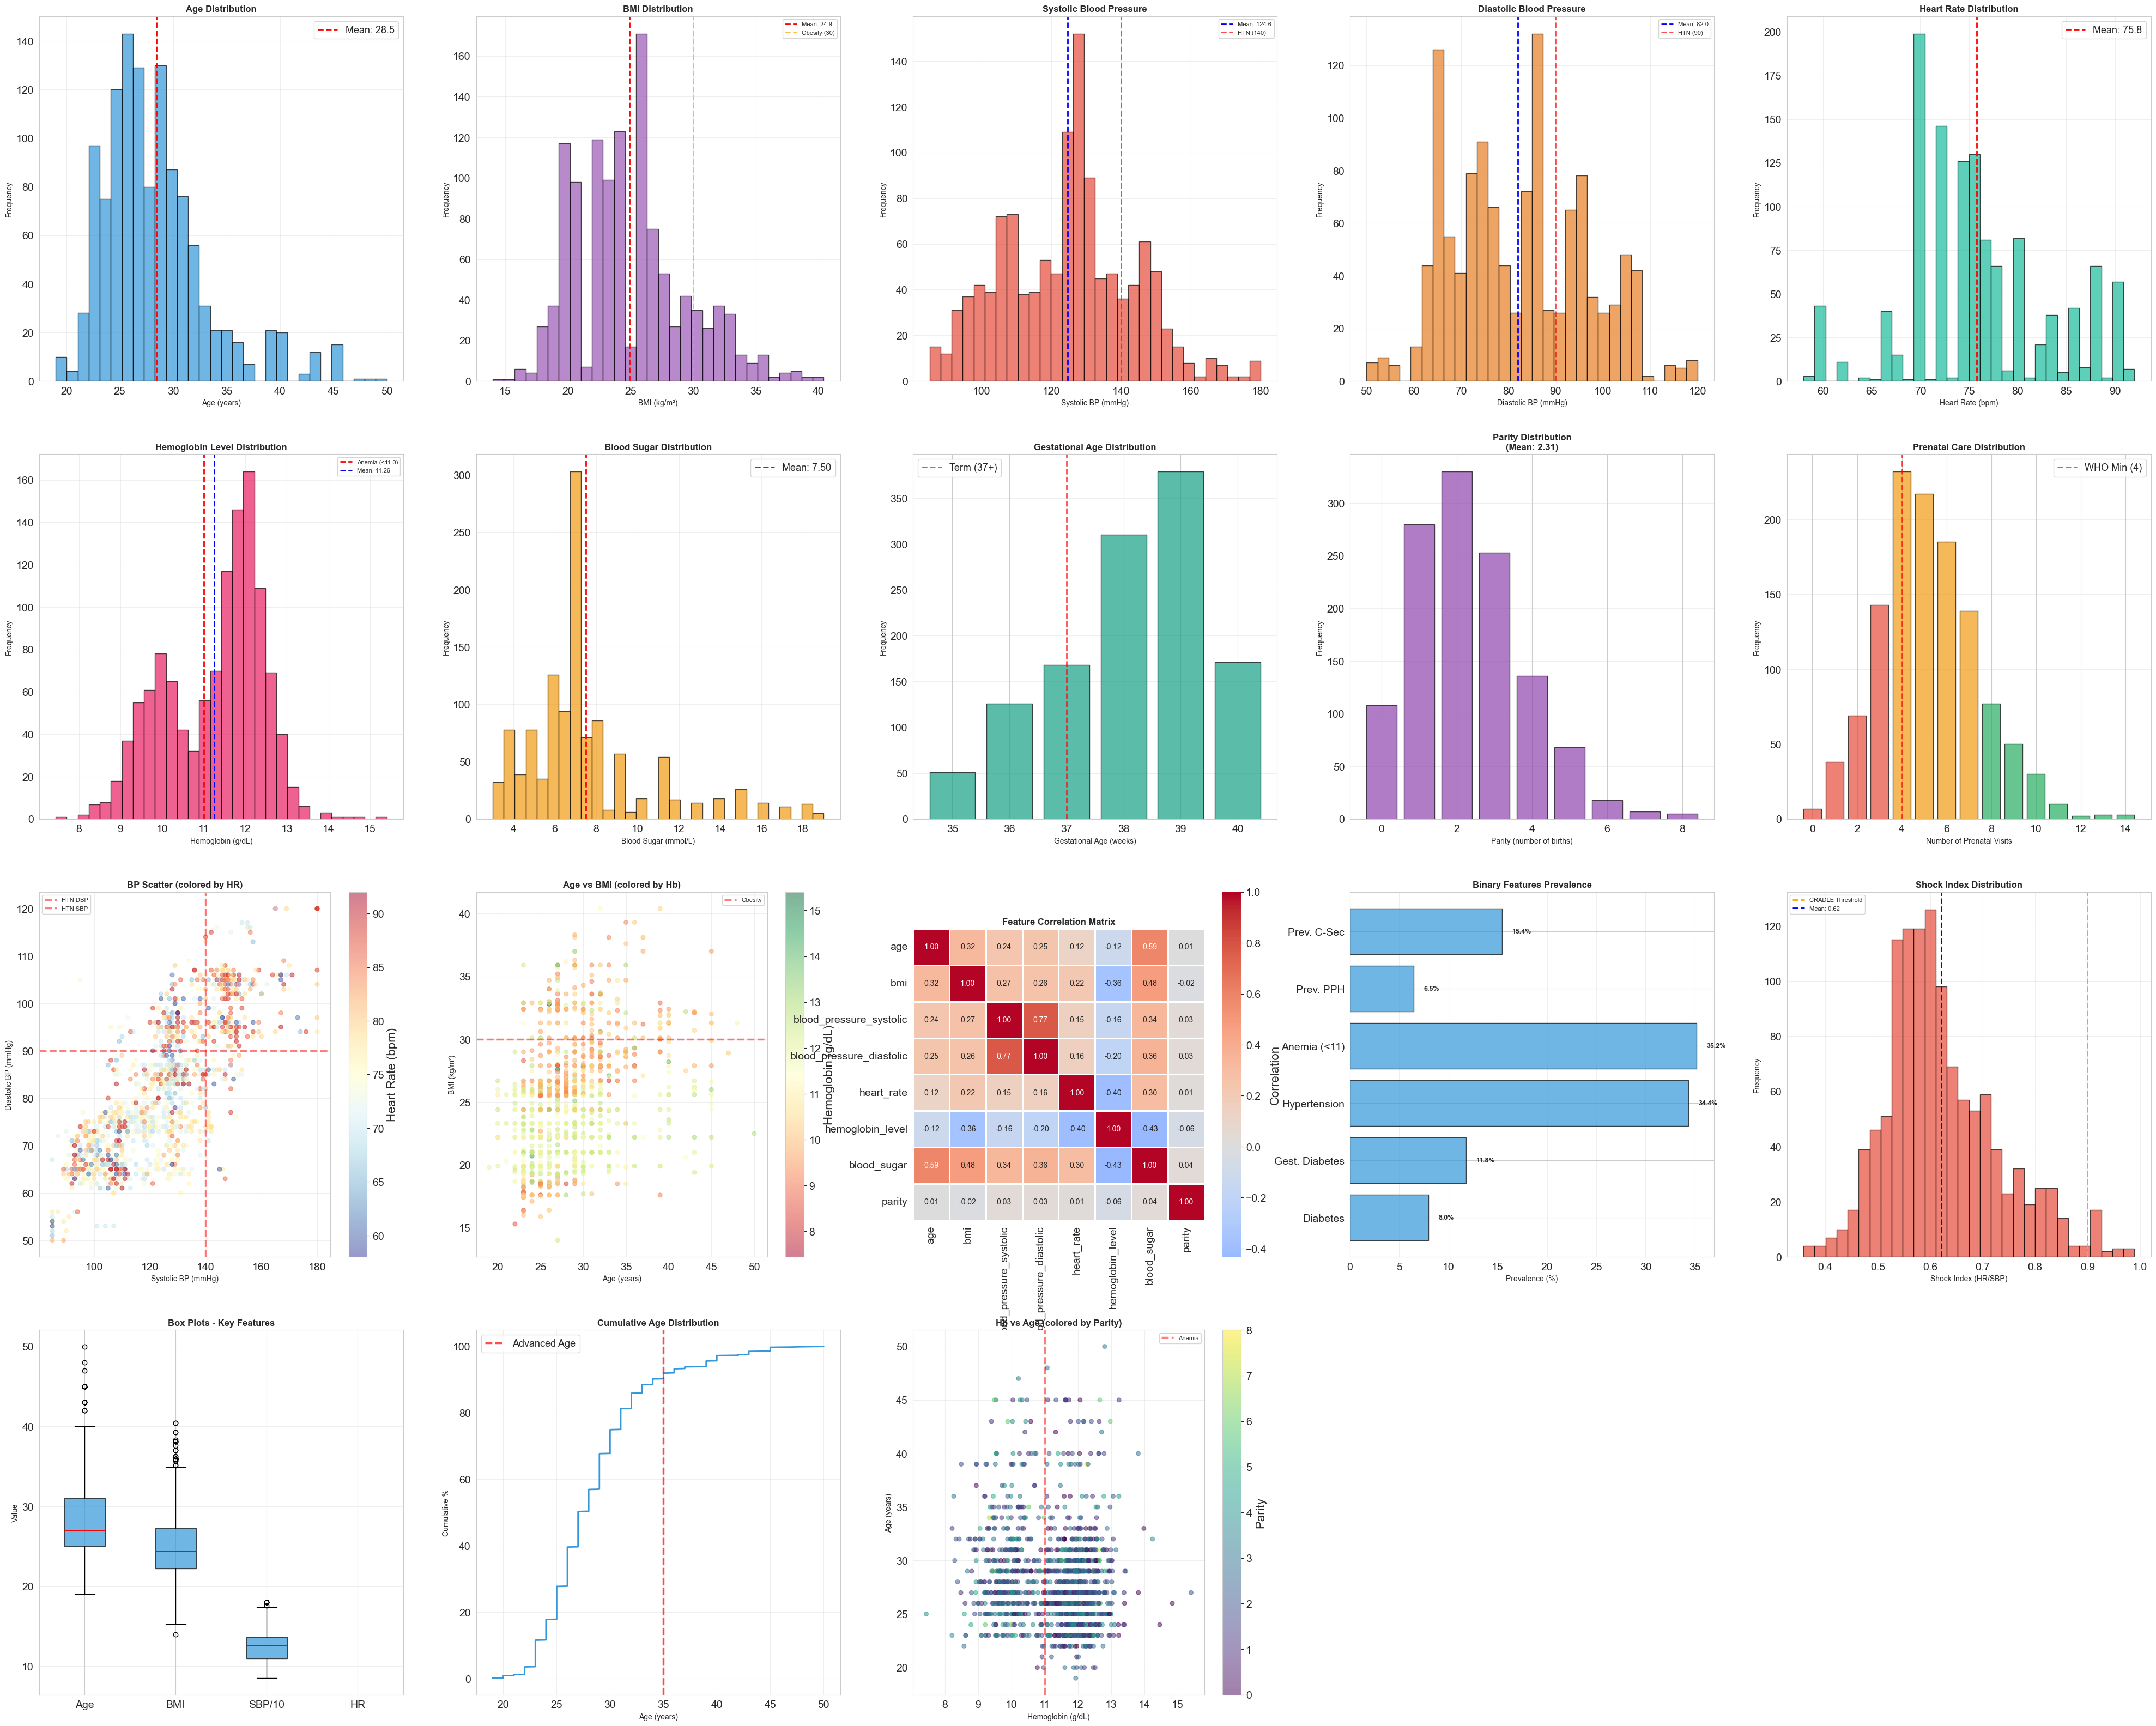

In [84]:
# Setting style
sns.set_style("whitegrid")
plt.rcParams['figure.facecolor'] = 'white'

# Creating comprehensive visualization
fig = plt.figure(figsize=(50, 40))

# Defining continuous features for visualization
continuous_features = [
    'age', 'bmi', 'blood_pressure_systolic', 'blood_pressure_diastolic',
    'heart_rate', 'hemoglobin_level', 'blood_sugar', 'gestational_age_weeks',
    'number_of_prenatal_visits', 'parity'
]

# AGE DISTRIBUTION
ax1 = plt.subplot(4, 5, 1)
ax1.hist(df_zimbabwe['age'], bins=30, color='#3498db', alpha=0.7, edgecolor='black')
ax1.axvline(df_zimbabwe['age'].mean(), color='red', linestyle='--', linewidth=2, 
           label=f'Mean: {df_zimbabwe["age"].mean():.1f}')
ax1.set_xlabel('Age (years)', fontsize=10)
ax1.set_ylabel('Frequency', fontsize=10)
ax1.set_title('Age Distribution', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# BMI DISTRIBUTION
ax2 = plt.subplot(4, 5, 2)
ax2.hist(df_zimbabwe['bmi'], bins=30, color='#9b59b6', alpha=0.7, edgecolor='black')
ax2.axvline(df_zimbabwe['bmi'].mean(), color='red', linestyle='--', linewidth=2,
           label=f'Mean: {df_zimbabwe["bmi"].mean():.1f}')
ax2.axvline(30, color='orange', linestyle='--', linewidth=2, alpha=0.7, label='Obesity (30)')
ax2.set_xlabel('BMI (kg/m²)', fontsize=10)
ax2.set_ylabel('Frequency', fontsize=10)
ax2.set_title('BMI Distribution', fontsize=12, fontweight='bold')
ax2.legend(fontsize=8)
ax2.grid(alpha=0.3)

# SYSTOLIC BP DISTRIBUTION
ax3 = plt.subplot(4, 5, 3)
ax3.hist(df_zimbabwe['blood_pressure_systolic'], bins=30, color='#e74c3c', alpha=0.7, edgecolor='black')
ax3.axvline(df_zimbabwe['blood_pressure_systolic'].mean(), color='blue', linestyle='--', 
           linewidth=2, label=f'Mean: {df_zimbabwe["blood_pressure_systolic"].mean():.1f}')
ax3.axvline(140, color='red', linestyle='--', linewidth=2, alpha=0.7, label='HTN (140)')
ax3.set_xlabel('Systolic BP (mmHg)', fontsize=10)
ax3.set_ylabel('Frequency', fontsize=10)
ax3.set_title('Systolic Blood Pressure', fontsize=12, fontweight='bold')
ax3.legend(fontsize=8)
ax3.grid(alpha=0.3)

# DIASTOLIC BP DISTRIBUTION
ax4 = plt.subplot(4, 5, 4)
ax4.hist(df_zimbabwe['blood_pressure_diastolic'], bins=30, color='#e67e22', alpha=0.7, edgecolor='black')
ax4.axvline(df_zimbabwe['blood_pressure_diastolic'].mean(), color='blue', linestyle='--',
           linewidth=2, label=f'Mean: {df_zimbabwe["blood_pressure_diastolic"].mean():.1f}')
ax4.axvline(90, color='red', linestyle='--', linewidth=2, alpha=0.7, label='HTN (90)')
ax4.set_xlabel('Diastolic BP (mmHg)', fontsize=10)
ax4.set_ylabel('Frequency', fontsize=10)
ax4.set_title('Diastolic Blood Pressure', fontsize=12, fontweight='bold')
ax4.legend(fontsize=8)
ax4.grid(alpha=0.3)

# HEART RATE DISTRIBUTION
ax5 = plt.subplot(4, 5, 5)
ax5.hist(df_zimbabwe['heart_rate'], bins=30, color='#1abc9c', alpha=0.7, edgecolor='black')
ax5.axvline(df_zimbabwe['heart_rate'].mean(), color='red', linestyle='--', linewidth=2,
           label=f'Mean: {df_zimbabwe["heart_rate"].mean():.1f}')
ax5.set_xlabel('Heart Rate (bpm)', fontsize=10)
ax5.set_ylabel('Frequency', fontsize=10)
ax5.set_title('Heart Rate Distribution', fontsize=12, fontweight='bold')
ax5.legend()
ax5.grid(alpha=0.3)

# HEMOGLOBIN DISTRIBUTION
ax6 = plt.subplot(4, 5, 6)
ax6.hist(df_zimbabwe['hemoglobin_level'], bins=30, color='#e91e63', alpha=0.7, edgecolor='black')
ax6.axvline(11.0, color='red', linestyle='--', linewidth=2, label='Anemia (<11.0)')
ax6.axvline(df_zimbabwe['hemoglobin_level'].mean(), color='blue', linestyle='--',
           linewidth=2, label=f'Mean: {df_zimbabwe["hemoglobin_level"].mean():.2f}')
ax6.set_xlabel('Hemoglobin (g/dL)', fontsize=10)
ax6.set_ylabel('Frequency', fontsize=10)
ax6.set_title('Hemoglobin Level Distribution', fontsize=12, fontweight='bold')
ax6.legend(fontsize=8)
ax6.grid(alpha=0.3)

# BLOOD SUGAR DISTRIBUTION
ax7 = plt.subplot(4, 5, 7)
ax7.hist(df_zimbabwe['blood_sugar'], bins=30, color='#f39c12', alpha=0.7, edgecolor='black')
ax7.axvline(df_zimbabwe['blood_sugar'].mean(), color='red', linestyle='--', linewidth=2,
           label=f'Mean: {df_zimbabwe["blood_sugar"].mean():.2f}')
ax7.set_xlabel('Blood Sugar (mmol/L)', fontsize=10)
ax7.set_ylabel('Frequency', fontsize=10)
ax7.set_title('Blood Sugar Distribution', fontsize=12, fontweight='bold')
ax7.legend()
ax7.grid(alpha=0.3)

# GESTATIONAL AGE DISTRIBUTION
ax8 = plt.subplot(4, 5, 8)
ga_counts = df_zimbabwe['gestational_age_weeks'].value_counts().sort_index()
ax8.bar(ga_counts.index, ga_counts.values, color='#16a085', alpha=0.7, edgecolor='black')
ax8.axvline(37, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Term (37+)')
ax8.set_xlabel('Gestational Age (weeks)', fontsize=10)
ax8.set_ylabel('Frequency', fontsize=10)
ax8.set_title('Gestational Age Distribution', fontsize=12, fontweight='bold')
ax8.legend()
ax8.grid(alpha=0.3, axis='y')

# PARITY DISTRIBUTION
ax9 = plt.subplot(4, 5, 9)
parity_counts = df_zimbabwe['parity'].value_counts().sort_index()
ax9.bar(parity_counts.index, parity_counts.values, color='#8e44ad', alpha=0.7, edgecolor='black')
ax9.set_xlabel('Parity (number of births)', fontsize=10)
ax9.set_ylabel('Frequency', fontsize=10)
ax9.set_title(f'Parity Distribution\n(Mean: {df_zimbabwe["parity"].mean():.2f})', 
             fontsize=12, fontweight='bold')
ax9.grid(alpha=0.3, axis='y')

# PRENATAL VISITS DISTRIBUTION
ax10 = plt.subplot(4, 5, 10)
visit_counts = df_zimbabwe['number_of_prenatal_visits'].value_counts().sort_index()
colors_visits = ['#e74c3c' if v < 4 else '#f39c12' if v < 8 else '#27ae60' for v in visit_counts.index]
ax10.bar(visit_counts.index, visit_counts.values, color=colors_visits, alpha=0.7, edgecolor='black')
ax10.axvline(4, color='red', linestyle='--', linewidth=2, alpha=0.7, label='WHO Min (4)')
ax10.set_xlabel('Number of Prenatal Visits', fontsize=10)
ax10.set_ylabel('Frequency', fontsize=10)
ax10.set_title('Prenatal Care Distribution', fontsize=12, fontweight='bold')
ax10.legend()
ax10.grid(alpha=0.3, axis='y')

# BLOOD PRESSURE SCATTER (SBP vs DBP)
ax11 = plt.subplot(4, 5, 11)
scatter = ax11.scatter(df_zimbabwe['blood_pressure_systolic'], 
                      df_zimbabwe['blood_pressure_diastolic'],
                      c=df_zimbabwe['heart_rate'], cmap='RdYlBu_r', 
                      alpha=0.5, s=30)
ax11.axhline(90, color='red', linestyle='--', alpha=0.5, label='HTN DBP')
ax11.axvline(140, color='red', linestyle='--', alpha=0.5, label='HTN SBP')
ax11.set_xlabel('Systolic BP (mmHg)', fontsize=10)
ax11.set_ylabel('Diastolic BP (mmHg)', fontsize=10)
ax11.set_title('BP Scatter (colored by HR)', fontsize=12, fontweight='bold')
plt.colorbar(scatter, ax=ax11, label='Heart Rate (bpm)')
ax11.legend(fontsize=8)
ax11.grid(alpha=0.3)

# AGE vs BMI SCATTER
ax12 = plt.subplot(4, 5, 12)
scatter2 = ax12.scatter(df_zimbabwe['age'], df_zimbabwe['bmi'],
                       c=df_zimbabwe['hemoglobin_level'], cmap='RdYlGn',
                       alpha=0.5, s=30)
ax12.axhline(30, color='red', linestyle='--', alpha=0.5, label='Obesity')
ax12.set_xlabel('Age (years)', fontsize=10)
ax12.set_ylabel('BMI (kg/m²)', fontsize=10)
ax12.set_title('Age vs BMI (colored by Hb)', fontsize=12, fontweight='bold')
plt.colorbar(scatter2, ax=ax12, label='Hemoglobin (g/dL)')
ax12.legend(fontsize=8)
ax12.grid(alpha=0.3)

# CORRELATION HEATMAP
ax13 = plt.subplot(4, 5, 13)
corr_features = ['age', 'bmi', 'blood_pressure_systolic', 'blood_pressure_diastolic',
                'heart_rate', 'hemoglobin_level', 'blood_sugar', 'parity']
corr_matrix = df_zimbabwe[corr_features].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
           ax=ax13, square=True, linewidths=1, cbar_kws={'label': 'Correlation'})
ax13.set_title('Feature Correlation Matrix', fontsize=12, fontweight='bold')

# BINARY FEATURES PREVALENCE
ax14 = plt.subplot(4, 5, 14)
binary_features = {
    'Diabetes': df_zimbabwe['preexisting_diabetes'].mean() * 100,
    'Gest. Diabetes': df_zimbabwe['gestational_diabetes'].mean() * 100,
    'Hypertension': ((df_zimbabwe['blood_pressure_systolic'] >= 140) | 
                    (df_zimbabwe['blood_pressure_diastolic'] >= 90)).mean() * 100,
    'Anemia (<11)': (df_zimbabwe['hemoglobin_level'] < 11.0).mean() * 100,
    'Prev. PPH': df_zimbabwe['previous_pph'].mean() * 100,
    'Prev. C-Sec': df_zimbabwe['previous_csection'].mean() * 100,
}
bars = ax14.barh(list(binary_features.keys()), list(binary_features.values()),
                color='#3498db', alpha=0.7, edgecolor='black')
ax14.set_xlabel('Prevalence (%)', fontsize=10)
ax14.set_title('Binary Features Prevalence', fontsize=12, fontweight='bold')
ax14.grid(alpha=0.3, axis='x')
for i, (bar, val) in enumerate(zip(bars, binary_features.values())):
    ax14.text(val + 1, bar.get_y() + bar.get_height()/2,
             f'{val:.1f}%', ha='left', va='center', fontsize=9, fontweight='bold')

# SHOCK INDEX DISTRIBUTION
ax15 = plt.subplot(4, 5, 15)
shock_index = df_zimbabwe['heart_rate'] / df_zimbabwe['blood_pressure_systolic']
ax15.hist(shock_index, bins=30, color='#e74c3c', alpha=0.7, edgecolor='black')
ax15.axvline(0.9, color='orange', linestyle='--', linewidth=2, label='CRADLE Threshold')
ax15.axvline(shock_index.mean(), color='blue', linestyle='--', linewidth=2,
            label=f'Mean: {shock_index.mean():.2f}')
ax15.set_xlabel('Shock Index (HR/SBP)', fontsize=10)
ax15.set_ylabel('Frequency', fontsize=10)
ax15.set_title('Shock Index Distribution', fontsize=12, fontweight='bold')
ax15.legend(fontsize=8)
ax15.grid(alpha=0.3)

# BOX PLOTS FOR KEY FEATURES
ax16 = plt.subplot(4, 5, 16)
box_data = [df_zimbabwe['age'], df_zimbabwe['bmi'], 
            df_zimbabwe['blood_pressure_systolic']/10,  # Scale for visibility
            df_zimbabwe['heart_rate']]
bp = ax16.boxplot(box_data, labels=['Age', 'BMI', 'SBP/10', 'HR'],
                  patch_artist=True, medianprops=dict(color='red', linewidth=2))
for patch in bp['boxes']:
    patch.set_facecolor('#3498db')
    patch.set_alpha(0.7)
ax16.set_ylabel('Value', fontsize=10)
ax16.set_title('Box Plots - Key Features', fontsize=12, fontweight='bold')
ax16.grid(alpha=0.3, axis='y')

# CUMULATIVE DISTRIBUTION - AGE
ax17 = plt.subplot(4, 5, 17)
age_sorted = np.sort(df_zimbabwe['age'])
cumulative = np.arange(1, len(age_sorted) + 1) / len(age_sorted) * 100
ax17.plot(age_sorted, cumulative, linewidth=2, color='#3498db')
ax17.axvline(35, color='red', linestyle='--', alpha=0.7, label='Advanced Age')
ax17.set_xlabel('Age (years)', fontsize=10)
ax17.set_ylabel('Cumulative %', fontsize=10)
ax17.set_title('Cumulative Age Distribution', fontsize=12, fontweight='bold')
ax17.legend()
ax17.grid(alpha=0.3)

# PAIRPLOT SAMPLE (Age vs Hb vs Parity)
ax18 = plt.subplot(4, 5, 18)
scatter3 = ax18.scatter(df_zimbabwe['hemoglobin_level'], df_zimbabwe['age'],
                       c=df_zimbabwe['parity'], cmap='viridis', alpha=0.5, s=30)
ax18.axvline(11.0, color='red', linestyle='--', alpha=0.5, label='Anemia')
ax18.set_xlabel('Hemoglobin (g/dL)', fontsize=10)
ax18.set_ylabel('Age (years)', fontsize=10)
ax18.set_title('Hb vs Age (colored by Parity)', fontsize=12, fontweight='bold')
plt.colorbar(scatter3, ax=ax18, label='Parity')
ax18.legend(fontsize=8)
ax18.grid(alpha=0.3)

viz_path = 'visualizations/df_zimbabwe_processes_visualization.png'
plt.savefig(viz_path, dpi=300, bbox_inches='tight', facecolor='white')

### Data Analysis and Cleaning for PPG Dataset

In [80]:
# Loading dataset
df = pd.read_csv('datasets/ppg_af_dataset.csv')
    
print(f"\n PPG Dataset Structure:")
print(f"Shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print(f"Data types:\n{df.dtypes}")
    
print(f"\n First 10 rows:")
print(df.head(10))
    
print(f"\n Basic Statistics:")
print(df.describe())


 PPG Dataset Structure:
Shape: (5250035, 5)
Columns: ['time', 'ppg', 'ecg', 'resp', 'status']
Data types:
time      float64
ppg       float64
ecg       float64
resp      float64
status      int64
dtype: object

 First 10 rows:
    time       ppg       ecg      resp  status
0  0.000  0.410557  0.314453  0.717097       0
1  0.008  0.400782  0.285156  0.720787       0
2  0.016  0.391007  0.300781  0.723247       0
3  0.024  0.382209  0.304688  0.726937       0
4  0.032  0.372434  0.294922  0.730627       0
5  0.040  0.363636  0.294922  0.733087       0
6  0.048  0.355816  0.294922  0.736777       0
7  0.056  0.348974  0.300781  0.740467       0
8  0.064  0.344086  0.300781  0.744157       0
9  0.072  0.339198  0.304688  0.746617       0

 Basic Statistics:
               time           ppg           ecg          resp        status
count  5.250035e+06  5.247136e+06  5.249660e+06  3.900026e+06  5.250035e+06
mean   6.000000e+02  9.497512e-01  4.150870e-01  2.368876e-01  5.428571e-01
std    

In [81]:
# Data quality assessment
print(f"\n Missing Values:")
missing = df.isnull().sum()
if missing.sum() > 0:
    for col, count in missing[missing > 0].items():
        pct = (count / len(df)) * 100
        print(f"{col:20s}: {count:6d} ({pct:5.2f}%)")
else:
    print("No missing values detected")

print(f"\n Data Range Analysis:")
for col in df.select_dtypes(include=[np.number]).columns:
    print(f"{col:20s}: [{df[col].min():10.4f}, {df[col].max():10.4f}]")

# Checking sampling rate
if 'time' in df.columns:
    time_diff = df['time'].diff()
    avg_sampling_interval = time_diff.mean()
    sampling_rate = 1 / avg_sampling_interval if avg_sampling_interval > 0 else None
    
    print(f"\n Temporal Characteristics:")
    print(f"Duration: {df['time'].max() - df['time'].min():.2f} seconds")
    print(f"Avg sampling interval: {avg_sampling_interval:.4f} seconds")
    if sampling_rate:
        print(f"Estimated sampling rate: {sampling_rate:.1f} Hz")


 Missing Values:
ppg                 :   2899 ( 0.06%)
ecg                 :    375 ( 0.01%)
resp                : 1350009 (25.71%)

 Data Range Analysis:
time                : [    0.0000,  1200.0000]
ppg                 : [    0.0000,     4.0020]
ecg                 : [   -0.5020,     1.5039]
resp                : [   -1.8465,     2.8442]
status              : [    0.0000,     1.0000]

 Temporal Characteristics:
Duration: 1200.00 seconds
Avg sampling interval: 0.0002 seconds
Estimated sampling rate: 4375.0 Hz


In [83]:
# Signal processing and feature extraction
if 'ppg' in df.columns:
    ppg_signal = df['ppg'].values
    
    # Removing outliers (values beyond 3 std)
    ppg_mean = np.mean(ppg_signal)
    ppg_std = np.std(ppg_signal)
    ppg_clean = np.where(
        np.abs(ppg_signal - ppg_mean) > 3 * ppg_std,
        ppg_mean,
        ppg_signal
    )
    
    print(f"\n Signal Cleaning:")
    print(f"Original samples: {len(ppg_signal)}")
    print(f"Outliers removed: {np.sum(ppg_signal != ppg_clean)}")
    
    # Applying bandpass filter (0.5-8 Hz for cardiac signal)
    if sampling_rate and sampling_rate > 16:
        nyquist = sampling_rate / 2
        low = 0.5 / nyquist
        high = 8.0 / nyquist
        
        b, a = butter(4, [low, high], btype='band')
        ppg_filtered = filtfilt(b, a, ppg_clean)
        
        print(f"Bandpass filter applied (0.5-8 Hz)")
    else:
        ppg_filtered = ppg_clean
        print(f"Sampling rate too low for optimal filtering")
    
    # Peak detection (for heart rate estimation)
    peaks, properties = find_peaks(
        ppg_filtered,
        distance=int(sampling_rate * 0.5) if sampling_rate else 50,  # Min 0.5s between peaks
        prominence=0.1
    )
    
    if len(peaks) > 1:
        # Calculating heart rate from peaks
        peak_intervals = np.diff(peaks) / sampling_rate if sampling_rate else np.diff(peaks)
        heart_rates = 60 / peak_intervals  # Convert to bpm
        avg_hr = np.mean(heart_rates)
        hr_std = np.std(heart_rates)
        
        print(f"\n Heart Rate Analysis:")
        print(f"Detected peaks: {len(peaks)}")
        print(f"Avg Heart Rate: {avg_hr:.1f} ± {hr_std:.1f} bpm")
        print(f"HR Range: [{np.min(heart_rates):.1f}, {np.max(heart_rates):.1f}] bpm")
    
    # Calculating PPG features relevant for PPH detection
    print(f"\n PPG Morphological Features:")
    
    # Pulse amplitude
    pulse_amplitude = np.max(ppg_filtered) - np.min(ppg_filtered)
    print(f"Pulse Amplitude: {pulse_amplitude:.4f}")
    
    # Signal quality index (ratio of signal power to noise power)
    signal_power = np.var(ppg_filtered)
    noise_power = np.var(ppg_signal - ppg_filtered)
    sqi = 10 * np.log10(signal_power / noise_power) if noise_power > 0 else np.inf
    print(f"Signal Quality Index: {sqi:.2f} dB")
    
    # Store in dataframe
    df['ppg_filtered'] = ppg_filtered

# Saving processed dataset
output_path = 'datasets/ppg_dataset_processed.csv'
df.to_csv(output_path, index=False)


 Signal Cleaning:
Original samples: 5250035
Outliers removed: 2899
Bandpass filter applied (0.5-8 Hz)

 PPG Morphological Features:
Pulse Amplitude: nan
Signal Quality Index: inf dB


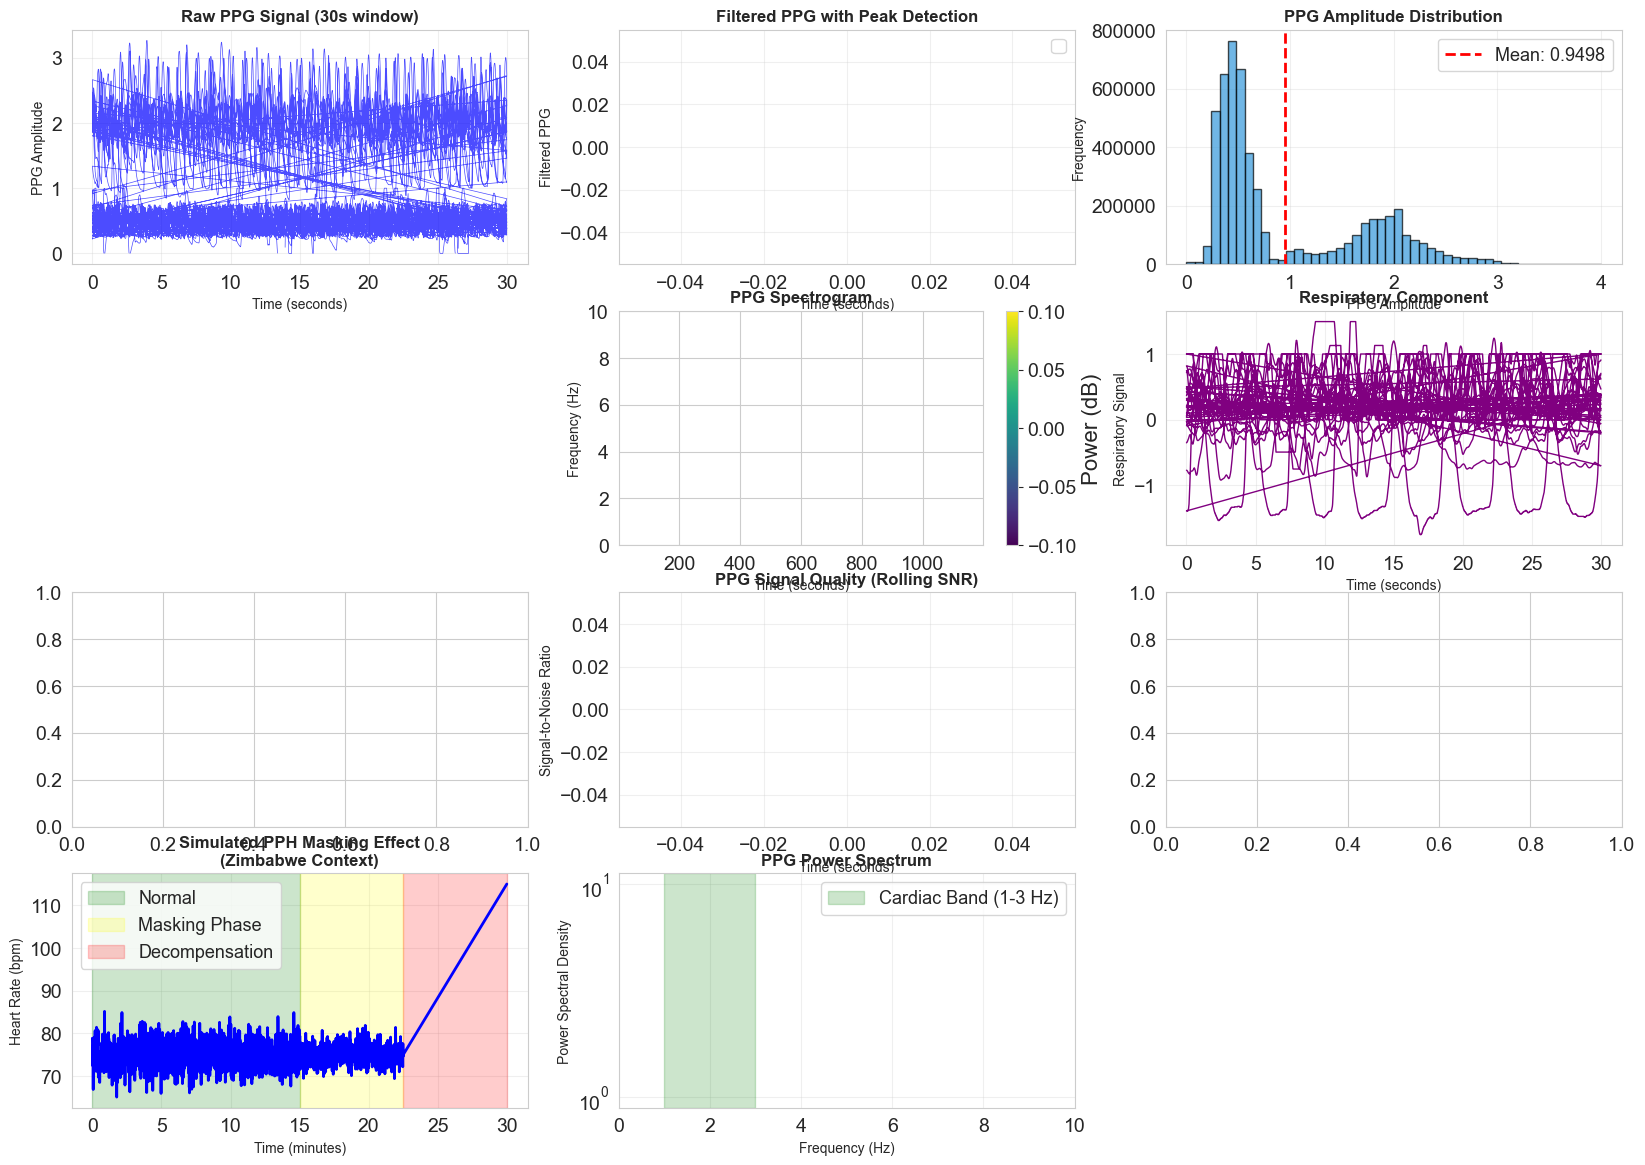

In [91]:
# Data Visualizations
fig = plt.figure(figsize=(20, 14))

# Raw PPG Signal (first 30 seconds)
ax1 = plt.subplot(4, 3, 1)
time_window = 30  # seconds
mask = df['time'] <= time_window
ax1.plot(df[mask]['time'], df[mask]['ppg'], 'b-', linewidth=0.5, alpha=0.7)
ax1.set_xlabel('Time (seconds)', fontsize=10)
ax1.set_ylabel('PPG Amplitude', fontsize=10)
ax1.set_title('Raw PPG Signal (30s window)', fontsize=12, fontweight='bold')
ax1.grid(alpha=0.3)

# Filtered PPG Signal
ax2 = plt.subplot(4, 3, 2)
if 'ppg_filtered' in df.columns:
    ax2.plot(df[mask]['time'], df[mask]['ppg_filtered'], 'g-', linewidth=0.8)
    if len(peaks) > 0:
        peaks_in_window = peaks[peaks < np.sum(mask)]
        ax2.plot(df['time'].iloc[peaks_in_window], 
                df['ppg_filtered'].iloc[peaks_in_window], 
                'ro', markersize=6, label='Detected Peaks')
    ax2.set_xlabel('Time (seconds)', fontsize=10)
    ax2.set_ylabel('Filtered PPG', fontsize=10)
    ax2.set_title('Filtered PPG with Peak Detection', fontsize=12, fontweight='bold')
    ax2.legend()
    ax2.grid(alpha=0.3)

# PPG Distribution
ax3 = plt.subplot(4, 3, 3)
ax3.hist(df['ppg'], bins=50, color='#3498db', alpha=0.7, edgecolor='black')
ax3.axvline(df['ppg'].mean(), color='red', linestyle='--', linewidth=2,
           label=f'Mean: {df["ppg"].mean():.4f}')
ax3.set_xlabel('PPG Amplitude', fontsize=10)
ax3.set_ylabel('Frequency', fontsize=10)
ax3.set_title('PPG Amplitude Distribution', fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(alpha=0.3)

# PPG Spectrogram
ax5 = plt.subplot(4, 3, 5)
if sampling_rate and len(ppg_filtered) > 256:
    f, t_spec, Sxx = signal.spectrogram(ppg_filtered, fs=sampling_rate, nperseg=256)
    pcm = ax5.pcolormesh(t_spec, f, 10 * np.log10(Sxx), shading='gouraud', cmap='viridis')
    ax5.set_ylabel('Frequency (Hz)', fontsize=10)
    ax5.set_xlabel('Time (seconds)', fontsize=10)
    ax5.set_title('PPG Spectrogram', fontsize=12, fontweight='bold')
    ax5.set_ylim([0, 10])  # Focus on cardiac frequencies
    plt.colorbar(pcm, ax=ax5, label='Power (dB)')

# Respiratory Signal
ax6 = plt.subplot(4, 3, 6)
if 'resp' in df.columns:
    ax6.plot(df[mask]['time'], df[mask]['resp'], 'purple', linewidth=1)
    ax6.set_xlabel('Time (seconds)', fontsize=10)
    ax6.set_ylabel('Respiratory Signal', fontsize=10)
    ax6.set_title('Respiratory Component', fontsize=12, fontweight='bold')
    ax6.grid(alpha=0.3)

# AF Status (if available)
ax7 = plt.subplot(4, 3, 7)
if 'af_dataset' in df.columns:
    af_counts = df['af_dataset'].value_counts()
    ax7.bar(af_counts.index, af_counts.values, color=['#27ae60', '#e74c3c'], alpha=0.7)
    ax7.set_xlabel('AF Status', fontsize=10)
    ax7.set_ylabel('Count', fontsize=10)
    ax7.set_title(f'Atrial Fibrillation Status\n({af_counts.get(1, 0)/len(df)*100:.1f}% AF)', 
                 fontsize=12, fontweight='bold')
    ax7.grid(alpha=0.3, axis='y')

# PPG Quality Metrics Over Time
ax8 = plt.subplot(4, 3, 8)
# Calculate rolling SNR
window_size = int(sampling_rate * 10) if sampling_rate else 1000  # 10-second windows
rolling_mean = pd.Series(ppg_filtered).rolling(window=window_size).mean()
rolling_std = pd.Series(ppg_filtered).rolling(window=window_size).std()
snr = rolling_mean / rolling_std

time_for_snr = df['time'][:len(snr)]
ax8.plot(time_for_snr, snr, 'orange', linewidth=1.5)
ax8.set_xlabel('Time (seconds)', fontsize=10)
ax8.set_ylabel('Signal-to-Noise Ratio', fontsize=10)
ax8.set_title('PPG Signal Quality (Rolling SNR)', fontsize=12, fontweight='bold')
ax8.grid(alpha=0.3)

# Pulse Interval Histogram
ax9 = plt.subplot(4, 3, 9)
if len(peaks) > 1:
    ax9.hist(peak_intervals, bins=30, color='#e91e63', alpha=0.7, edgecolor='black')
    ax9.axvline(np.mean(peak_intervals), color='blue', linestyle='--', linewidth=2,
               label=f'Mean: {np.mean(peak_intervals):.3f}s')
    ax9.set_xlabel('Pulse Interval (seconds)', fontsize=10)
    ax9.set_ylabel('Frequency', fontsize=10)
    ax9.set_title('Pulse Interval Distribution', fontsize=12, fontweight='bold')
    ax9.legend()
    ax9.grid(alpha=0.3)

# Simulated Physiological Masking Scenario
ax10 = plt.subplot(4, 3, 10)
# Create synthetic PPH scenario showing masking effect
time_scenario = np.linspace(0, 30, 3000)  # 30 minutes
hr_normal = 75 + np.random.normal(0, 3, 1500)
hr_masked = 75 + np.random.normal(0, 2, 750)  # Deceptively stable
hr_decomp = 75 + np.linspace(0, 40, 750)  # Rapid increase

hr_scenario = np.concatenate([hr_normal, hr_masked, hr_decomp])
ax10.plot(time_scenario, hr_scenario, 'b-', linewidth=2)
ax10.axvspan(0, 15, alpha=0.2, color='green', label='Normal')
ax10.axvspan(15, 22.5, alpha=0.2, color='yellow', label='Masking Phase')
ax10.axvspan(22.5, 30, alpha=0.2, color='red', label='Decompensation')
ax10.set_xlabel('Time (minutes)', fontsize=10)
ax10.set_ylabel('Heart Rate (bpm)', fontsize=10)
ax10.set_title('Simulated PPH Masking Effect\n(Zimbabwe Context)', fontsize=12, fontweight='bold')
ax10.legend(loc='upper left')
ax10.grid(alpha=0.3)

# Power Spectral Density
ax11 = plt.subplot(4, 3, 11)
if sampling_rate:
    freqs, psd = signal.welch(ppg_filtered, fs=sampling_rate, nperseg=1024)
    ax11.semilogy(freqs, psd, 'b-', linewidth=2)
    ax11.axvspan(1, 3, alpha=0.2, color='green', label='Cardiac Band (1-3 Hz)')
    ax11.set_xlabel('Frequency (Hz)', fontsize=10)
    ax11.set_ylabel('Power Spectral Density', fontsize=10)
    ax11.set_title('PPG Power Spectrum', fontsize=12, fontweight='bold')
    ax11.set_xlim([0, 10])
    ax11.legend()
    ax11.grid(alpha=0.3)

viz_path = 'visualizations/ppg_dataset_visualization.png'
plt.savefig(viz_path, dpi=300, bbox_inches='tight', facecolor='white')
 